<a href="https://colab.research.google.com/github/alok13/Machine-Learning/blob/master/Devnagri_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64


Download the data

In [0]:
# Helper function to download data and extract
import os
import zipfile
def get_data_extract():
  if "DevanagariHandwrittenCharacterDataset" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    fileExtract = !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip
    print("Dataset downloaded!")
    print("Extracting data..")
    
    with zipfile.ZipFile("DevanagariHandwrittenCharacterDataset.zip", 'r') as zip_ref:
      zip_ref.extractall("")
    #!tar xzvf DevanagariHandwrittenCharacterDataset.zip
    print("done!")

In [5]:
get_data_extract()

Dataset downloaded!
Extracting data..
done!


In [0]:
path=Path("DevanagariHandwrittenCharacterDataset")

In [7]:
path.ls()

[PosixPath('DevanagariHandwrittenCharacterDataset/Train'),
 PosixPath('DevanagariHandwrittenCharacterDataset/Test')]

In [8]:
train_path= path/'Train'
test_path = path/'Test'

print(len(os.listdir(train_path)))

46


When tried to direct input to **len()** it didnt work out. Alway convert it to list first and then print length.

Rename **test** folder to **valid** becuase ImageDataBunch.fromFolder expects it.Also changed **Train** to **train**.

In [0]:
os.rename(test_path, path/'valid')
os.rename(train_path, path/'train')

Get data fron folder structure.

In [0]:
data = ImageDataBunch.from_folder(path, size=26)

View some of the pictures.

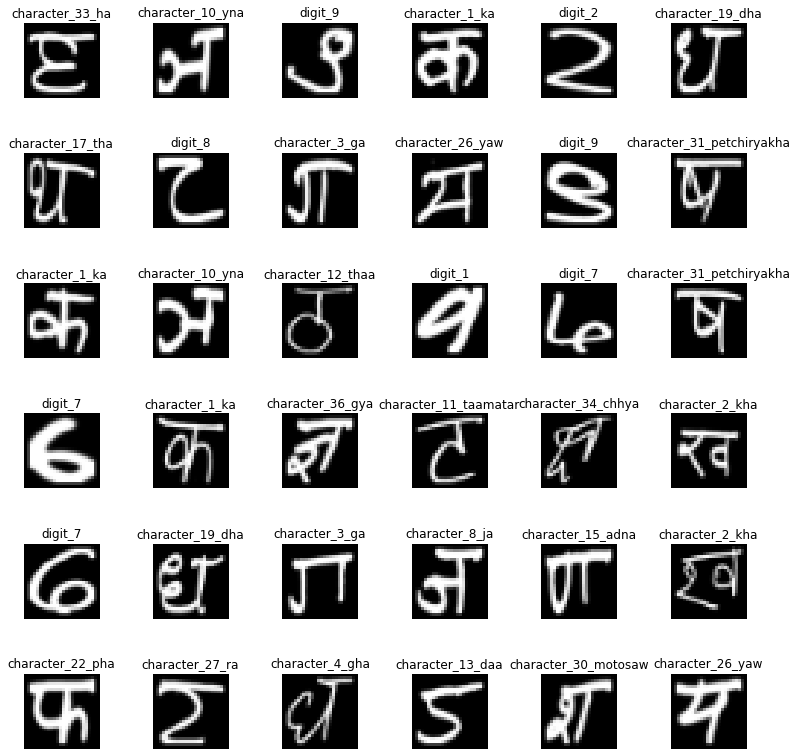

In [11]:
data.show_batch(rows=6, figsize=(11,11))

Check the classes 

In [12]:
print(data.classes)

['character_10_yna', 'character_11_taamatar', 'character_12_thaa', 'character_13_daa', 'character_14_dhaa', 'character_15_adna', 'character_16_tabala', 'character_17_tha', 'character_18_da', 'character_19_dha', 'character_1_ka', 'character_20_na', 'character_21_pa', 'character_22_pha', 'character_23_ba', 'character_24_bha', 'character_25_ma', 'character_26_yaw', 'character_27_ra', 'character_28_la', 'character_29_waw', 'character_2_kha', 'character_30_motosaw', 'character_31_petchiryakha', 'character_32_patalosaw', 'character_33_ha', 'character_34_chhya', 'character_35_tra', 'character_36_gya', 'character_3_ga', 'character_4_gha', 'character_5_kna', 'character_6_cha', 'character_7_chha', 'character_8_ja', 'character_9_jha', 'digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9']


In [13]:
len(data.classes)

46

## Training: resnet34
Now we will start training our model using pretrained resnet34 model.

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 126MB/s] 


In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.541513,1.093680,0.318116,0.681884,02:04
1,0.722236,0.447832,0.137536,0.862464,02:01
2,0.449241,0.285856,0.089130,0.910870,02:02
3,0.399445,0.254516,0.076812,0.923188,02:01


In [0]:
learn.save('stage-1')

Got our first trial result. Accuracy is close to 92.3%. Now we will try to fine tune some hyperparameters and try to do better.

In [0]:

learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


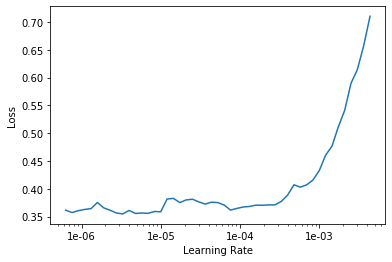

In [19]:

learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.306497,0.187546,0.059275,0.940725,02:21
1,0.213315,0.136894,0.040942,0.959058,02:21
2,0.177442,0.130115,0.038188,0.961812,02:21


Our accuracy improved to 96%.

In [0]:
learn.save('stage-2')

In [22]:
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.154619,0.114424,0.035145,0.964855,02:15


In [0]:
learn.save('stage-3')

## Interpretation and analysis of result

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

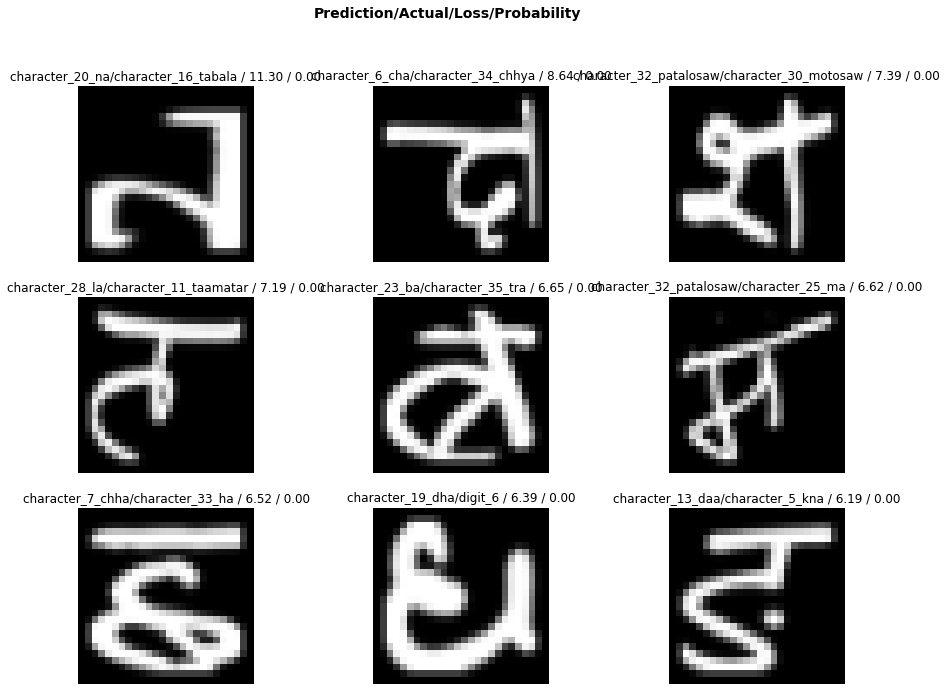

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
This looks promising, since these top loss character are unclear and can be misundertood.

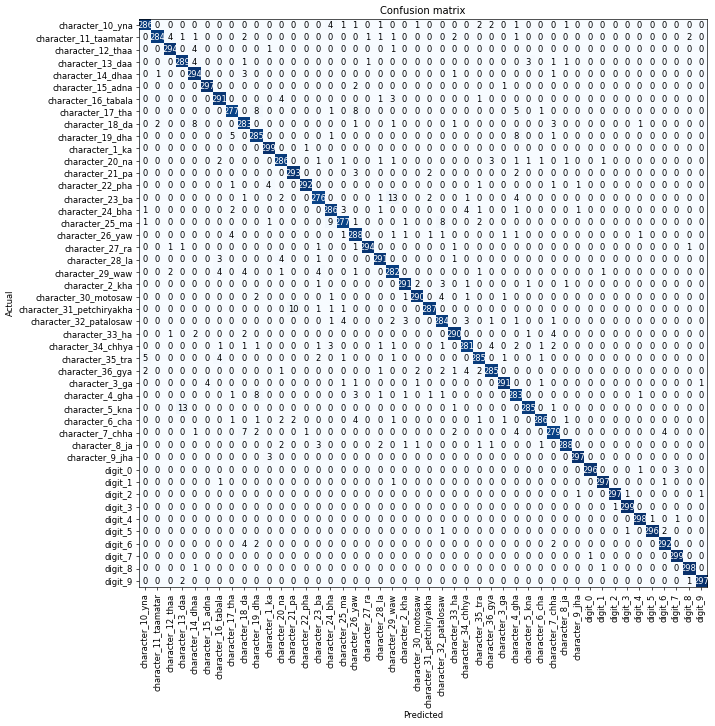

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('character_23_ba', 'character_29_waw', 13),
 ('character_5_kna', 'character_13_daa', 13),
 ('character_31_petchiryakha', 'character_21_pa', 10),
 ('character_25_ma', 'character_24_bha', 9),
 ('character_17_tha', 'character_19_dha', 8),
 ('character_17_tha', 'character_26_yaw', 8),
 ('character_18_da', 'character_14_dhaa', 8),
 ('character_19_dha', 'character_4_gha', 8),
 ('character_25_ma', 'character_32_patalosaw', 8),
 ('character_4_gha', 'character_19_dha', 8),
 ('character_7_chha', 'character_18_da', 7),
 ('character_17_tha', 'character_4_gha', 5),
 ('character_19_dha', 'character_17_tha', 5),
 ('character_35_tra', 'character_10_yna', 5),
 ('character_10_yna', 'character_24_bha', 4),
 ('character_11_taamatar', 'character_12_thaa', 4),
 ('character_12_thaa', 'character_14_dhaa', 4),
 ('character_13_daa', 'character_14_dhaa', 4),
 ('character_16_tabala', 'character_20_na', 4),
 ('character_22_pha', 'character_1_ka', 4),
 ('character_23_ba', 'character_4_gha', 4),
 ('character_24_bh

Training can be continued even after saved model-3 but that would have caused overfitting. Hence stopping at this stage.